# Corpus EDA

In [1]:
import pandas as pd
import random

import string 
import re

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

In [61]:
other_punct = ['’', '“','”', "''", '""', '', '..', '...', '``', '—', '->', '’ ’']
eng_stopwords_and_punct = stopwords.words('english') + list(string.punctuation) + other_punct
                           
# TweetTokenizer will put all text in the tweet to lowercase, strip out usernames/handles and reduce repeated chars in words
tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True) 

lemmatizer = WordNetLemmatizer()


def clean_tokenize_lemmatize_tweet(tweet):
    ''' 
    Apply text cleaning, tokenization then lemmatization on the given tweet 
    '''
    #remove urls
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    #remove RT 
    tweet = re.sub(r'^RT\s+', '', tweet)
    #remove the # symbol
    tweet = re.sub('#', '', tweet)
    #remove words containing numbers
    tweet = re.sub(r'\w*\d\w*', '', tweet)
    #tokenize
    tokens = tweet_tokenizer.tokenize(tweet)
    # remove stopwords and punctuation
    tokens = [token for token in tokens if token not in eng_stopwords_and_punct]
    # remove tokens that are only 1 char in length
    tokens = [token for token in tokens if len(token)>1]
    #lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens


def split_content_by_sentiment(region_df):
    '''
    Create dataframes for each sentiment class from the provided dataframe
    '''
    pos = region_df[region_df['sentiment'] == 'positive']['content']
    neg = region_df[region_df['sentiment'] == 'negative']['content']
    neu = region_df[region_df['sentiment'] == 'neutral']['content']
    return [pos, neg, neu]


def perform_topic_modeling_and_plot(content, 
                                    topic_num, 
                                    top_word_count, 
                                    plot_title, 
                                    plot_figsize,
                                    plot_color):
    '''
    Perform topic modeing using on the provided corpus and plot the top words 
    for the designated number of topics.
    '''
    cv = CountVectorizer(max_df=0.95, 
                         min_df=0.01, 
                         strip_accents='unicode', 
                         tokenizer=clean_tokenize_lemmatize_tweet, 
                         ngram_range=(1,2))

    lda = LatentDirichletAllocation(max_iter=10,
                                    learning_method='online', 
                                    n_components=topic_num, 
                                    random_state=42)

    # Unsupervised learning...no need to do a test/train split here ;)
    dtm = cv.fit_transform(content)

    # This might take awhile if you are dealing with a large amount of documents!
    lda.fit(dtm)
    # plot the top words per topic
    feature_names = cv.get_feature_names()

    num_cols = topic_num
    num_rows = 1
    if topic_num == 10:
        num_rows = 2
        num_cols = 5

    plot_top_words(lda, 
                   feature_names, 
                   top_word_count, 
                   plot_title, 
                   plot_num_rows=num_rows,
                   plot_num_cols=num_cols,
                   plot_figsize=plot_figsize,
                   plot_color=plot_color)


def plot_top_words(fitted_lda, 
                   feature_names,
                    n_top_words, 
                    title, 
                    plot_num_rows, 
                    plot_num_cols, 
                    plot_figsize,
                    plot_color='blue'):
    '''
    Plot the top words for the provided topic model
    '''
    fig, axes = plt.subplots(plot_num_rows, plot_num_cols, figsize=plot_figsize, sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(fitted_lda.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.5, color=plot_color, alpha=0.75)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 14})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=12)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=18)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.95, hspace=0.10)
    plt.show()

## Corpus Exploration: Topic Modeling

Now that we've assigned Sentiment to the Tweets, let's look into what people are tweeting about. I'm using unsupervised learning to perform Topic Modeling on each Sentiment group in the following way:
* Topics for Pos/Neg/Neu tweets from the entire United States 
* Topics for Pos/Neg/Neu tweets from the Southeast (this is the region where I currently live.) 
* Topics for Pos/Neg/Neu tweets from Alabama (this is the state where I currently live and most of my family members have children in K-12 in this state.) 

In [3]:
vetted_usa_tweets = pd.read_csv('../data/vetted_usa_tweets.csv')

west_tweets = vetted_usa_tweets[vetted_usa_tweets['region'] == 'West']
midwest_tweets = vetted_usa_tweets[vetted_usa_tweets['region'] == 'Midwest']
southwest_tweets = vetted_usa_tweets[vetted_usa_tweets['region'] == 'Southwest']
southeast_tweets = vetted_usa_tweets[vetted_usa_tweets['region'] == 'Southeast']
northeast_tweets = vetted_usa_tweets[vetted_usa_tweets['region'] == 'Northeast']

In [4]:
# Series of Tweets by Region
us_tweets_text = vetted_usa_tweets['content']
west_tweets_text = west_tweets['content']
midwest_tweets_text = midwest_tweets['content']
southwest_tweets_text = southwest_tweets['content']
southeast_tweets_text = southwest_tweets['content']
northeast_tweets_text = southwest_tweets['content']

In [66]:
# Get the Tweets by Sentiment for selected geo regions and states
entire_us_sentiment_series = split_content_by_sentiment(vetted_usa_tweets)

se_sentiment_series = split_content_by_sentiment(southeast_tweets)

alabama_tweets = southeast_tweets[southeast_tweets['loc_state'] == 'AL']
alabama_tweets_text = alabama_tweets['content']
alabama_sentiment_series = split_content_by_sentiment(alabama_tweets)

### Text Processing to prep for Topic Modeling

Before performing topic modeling using LatentDirichletAllocation (LDA), I'll need apply some text processing. When I trained the Text Classifier to detect sentiment, punctuation and capitalization could actually be useful to the classifer, so I only did very light text processing to the corpus before trainging the classifier. With Topic Modeling, it is more important to normalize the corpus text so I'll apply the following text processing to prepare.

* Change to lowercase  (TweetTokenizer handles this)
* Remove RT and # (will need a regex)
* Remove urls (will need a regex)
* Remove stopwords and punctuation
* Peform lemmatization (after all other cleaning applied, apply lemmatization)

Text processing and Topic Modeling are peformed in the __clean_tokenize_lemmatize_tweet__ and the __perform_topic_modeling__ functions 


## Question 4a: What are the Topics for Positive, Negative, and Neutral Tweets in the US, the Southeast Region, and the state of Alabama?
-----------------
## Question 4b: If we perform Topic Modeling on all Tweets, will the Tweets get grouped into topics that align with the Topics by Sentiment?

## Topic modeling for US 

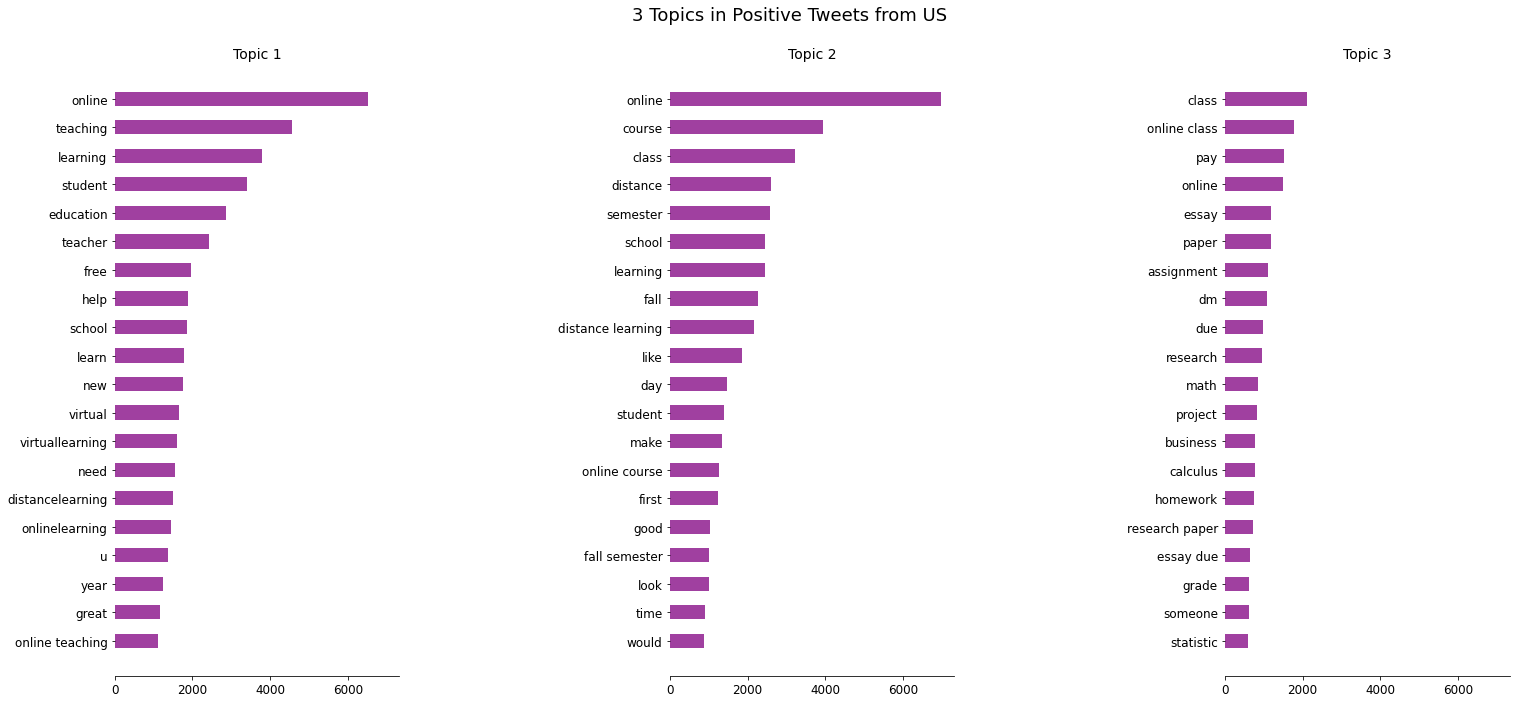

In [106]:
# US-wide Positive topic 
perform_topic_modeling_and_plot(content=entire_us_sentiment_series[0], 
                                topic_num=3, 
                                top_word_count=20, 
                                plot_title='3 Topics in Positive Tweets from US',
                                plot_figsize=(25,10),
                                plot_color='purple')

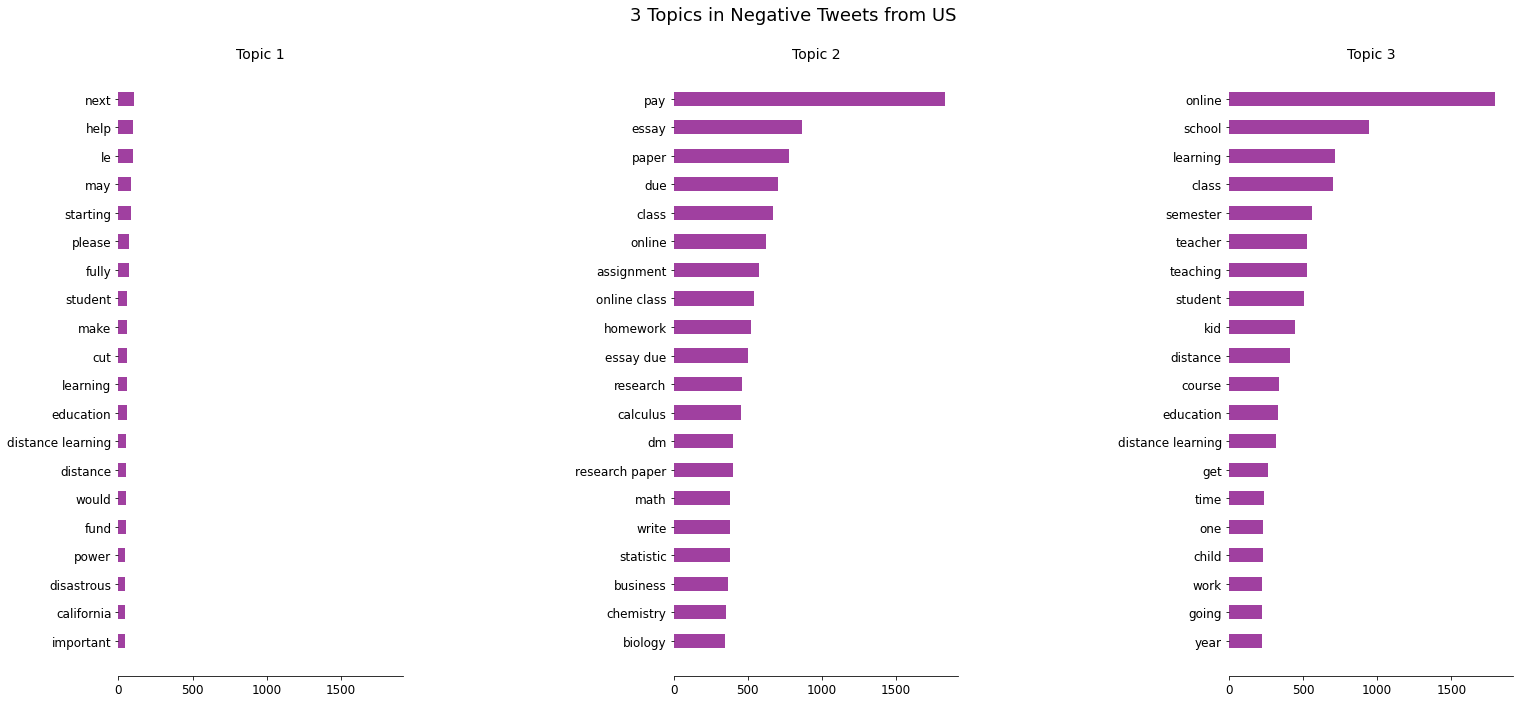

In [107]:
# US-wide Negative topics
perform_topic_modeling_and_plot(content=entire_us_sentiment_series[1], 
                                topic_num=3, 
                                top_word_count=20, 
                                plot_title='3 Topics in Negative Tweets from US',
                                plot_figsize=(25,10),
                                plot_color='purple')


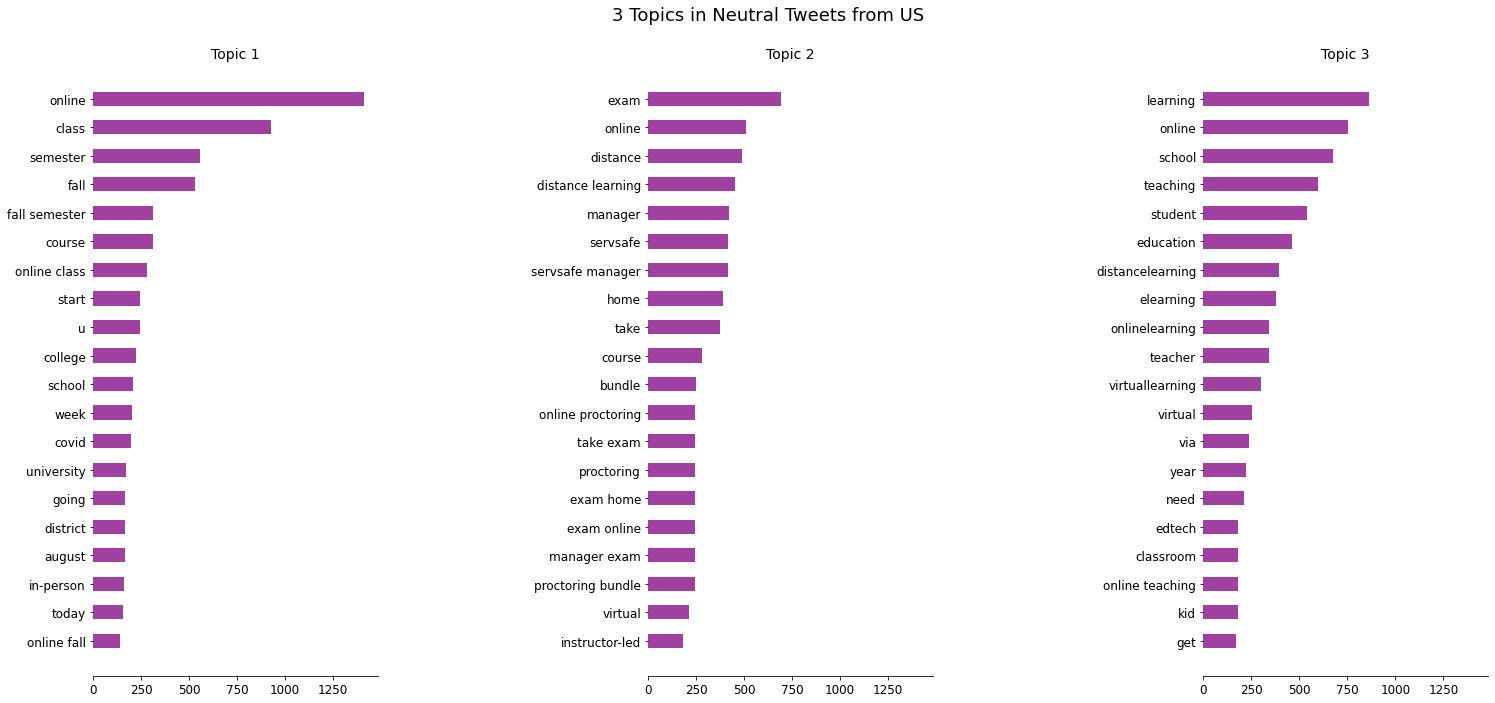

In [108]:
## US-wide Neutral topics
perform_topic_modeling_and_plot(content=entire_us_sentiment_series[2], 
                                topic_num=3, 
                                top_word_count=20, 
                                plot_title='3 Topics in Neutral Tweets from US',
                                plot_figsize=(25,10),
                                plot_color='purple')

## Human determined topic descriptions are below:
### US Positive 
#### Topic 1: Online Teaching Support and Info
#### Topic 2: Online Class/Learning General Info 
#### Topic 3: Online Class Assignments
---------------------------------------------

### US Negative 
#### Topic 1: Needing Assistance
#### Topic 2: Paying for Assignments on many Topics
#### Topic 3: Online Learning 

---------------------------------------------
### US Neutral
#### Topic 1: Start of Online Learing in Aug 2020
#### Topic 2: Exam Proctoring 
#### Topic 3: Online Teaching 

### Dividing all US Tweets into 3 Topics

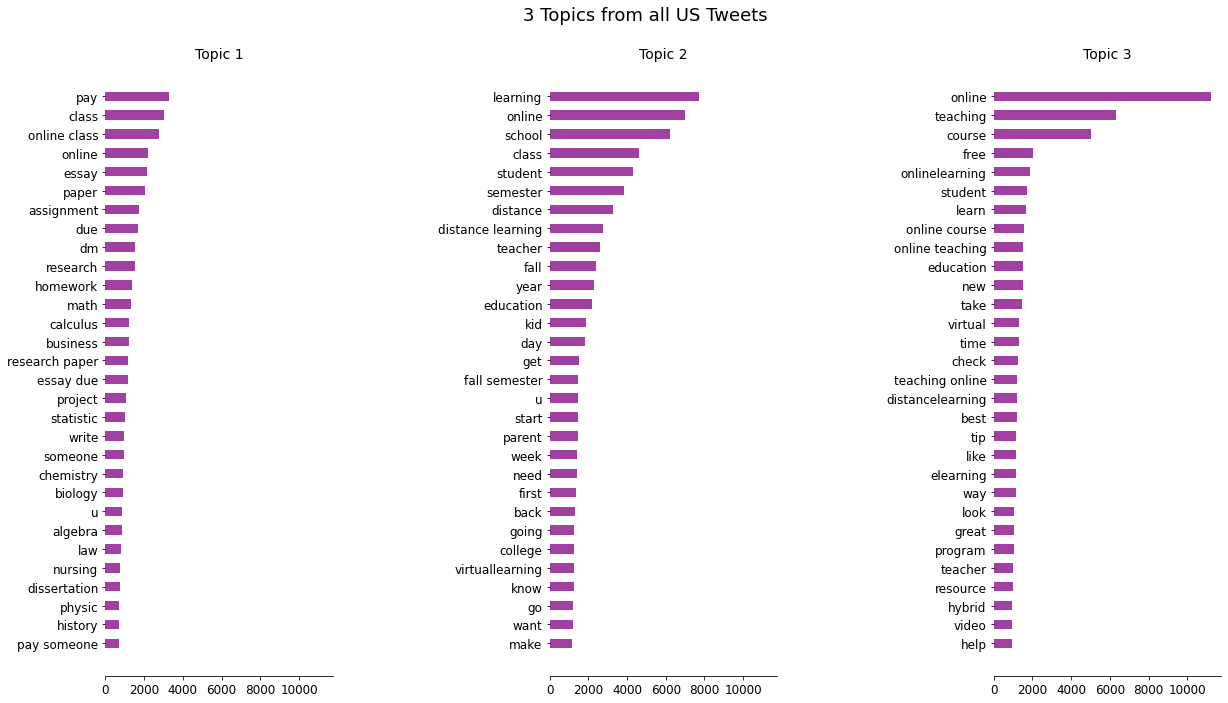

In [109]:
perform_topic_modeling_and_plot(content=us_tweets_text, 
                                topic_num=3, 
                                top_word_count=30, 
                                plot_title='3 Topics from all US Tweets',
                                plot_figsize=(20,10),
                                plot_color='purple')


## Do topics detected in all US Tweets align with topics detected in Pos/Neg/Neu US Tweets?

### Topic 1: Paying for Online Classes or for Online Class Assignments
* __VERY__ aligned to  _Negative Topic 2: Paying for Assignments on many Topics_

### Topic 2: Online Learning/School Information
* __SOMEWHAT__ aligned to _Positive Topic 2: Online Class/Learning General Info_ 

### Topic 3: Online Teaching Resources/Support
* __VERY__ aligned to _Positive Topic 1: Online Teaching Support and Info_


## Topic modeling for Southeast

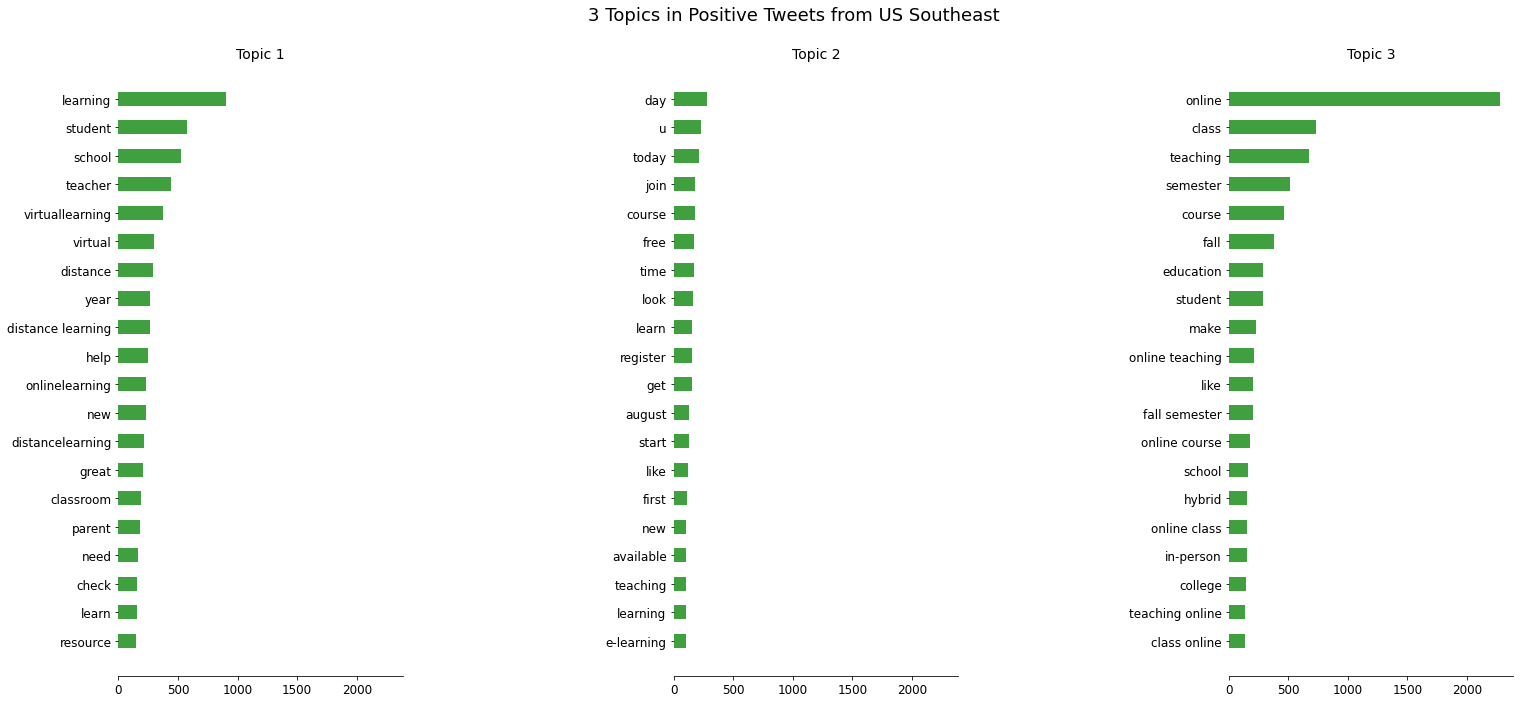

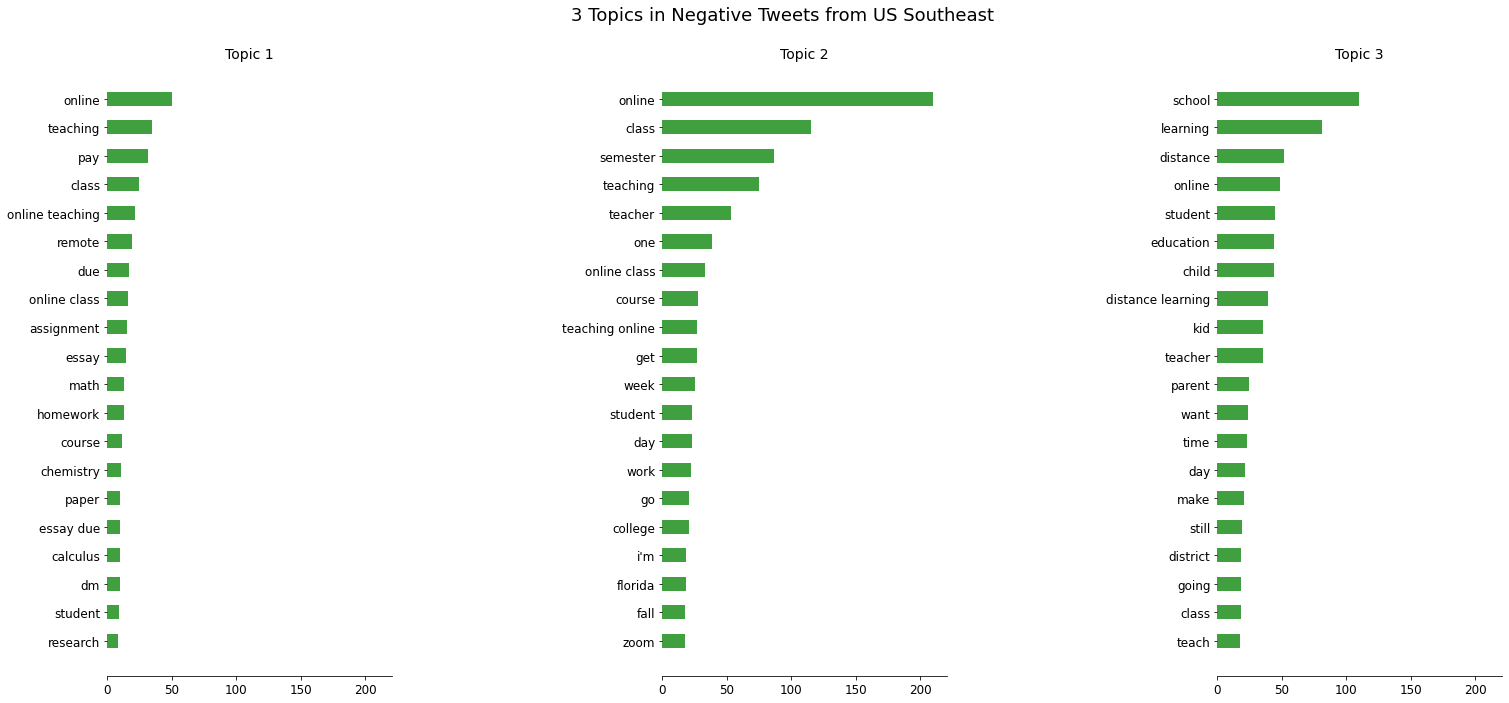

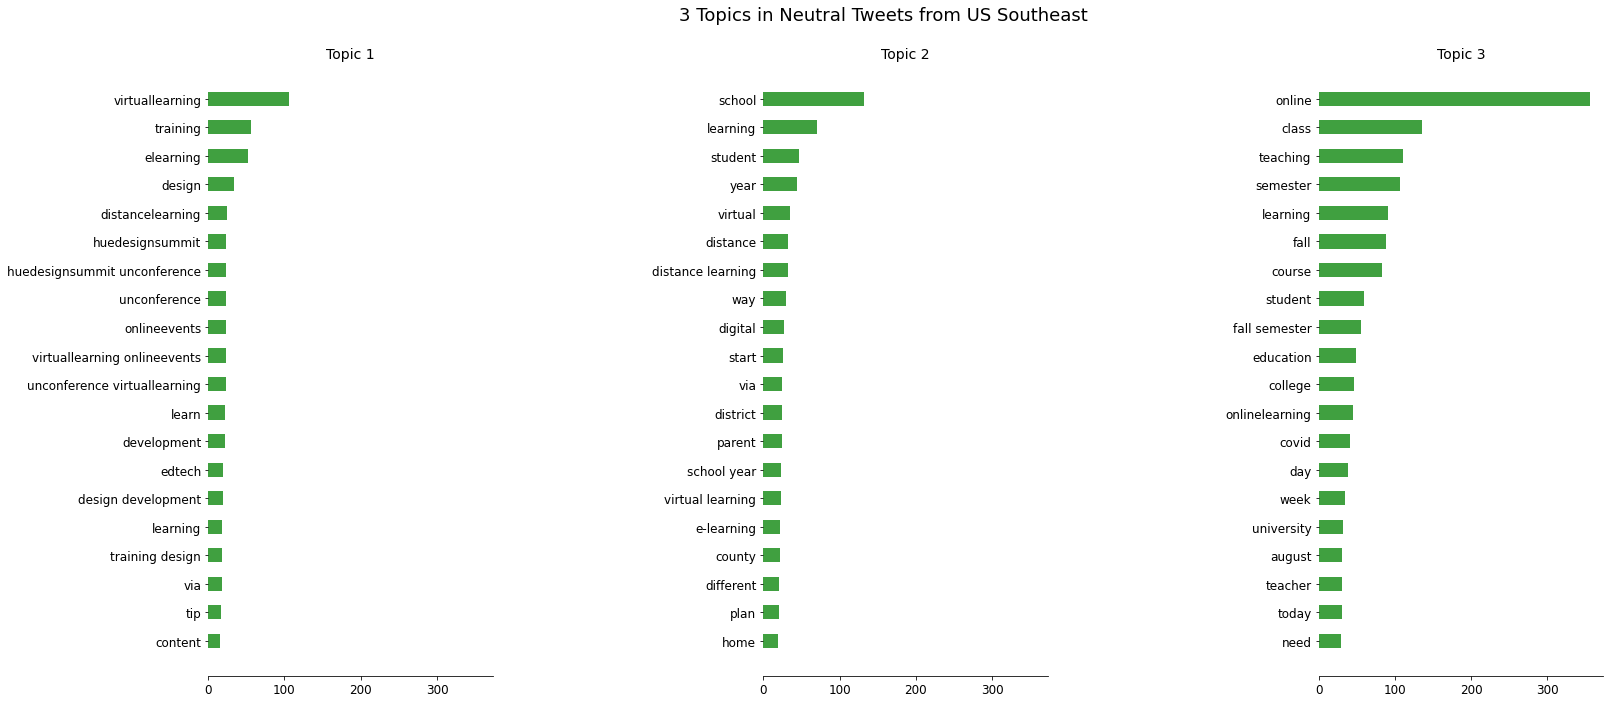

In [104]:
# Southeast Positive topics 
perform_topic_modeling_and_plot(content=se_sentiment_series[0], 
                                topic_num=3, 
                                top_word_count=20, 
                                plot_title='3 Topics in Positive Tweets from US Southeast',
                                plot_figsize=(25,10),
                                plot_color='green')


# Southeast Negative topics 
perform_topic_modeling_and_plot(content=se_sentiment_series[1], 
                                topic_num=3, 
                                top_word_count=20, 
                                plot_title='3 Topics in Negative Tweets from US Southeast',
                                plot_figsize=(25,10),
                                plot_color='green')


# Southeast Neutral topics
perform_topic_modeling_and_plot(content=se_sentiment_series[2], 
                                topic_num=3, 
                                top_word_count=20, 
                                plot_title='3 Topics in Neutral Tweets from US Southeast',
                                plot_figsize=(25,10),
                                plot_color='green')


## Human determined topic descriptions are below:
### Southeast Positive 
#### Topic 1: Student Virtual/Distance Learning
#### Topic 2: Registering for Course(s)
#### Topic 3: Online teaching
---------------------------------------------

### Southeast Negative 
#### Topic 1: Paying for Online Assignments
#### Topic 2: Teaching the Semeter Online
#### Topic 3: Distance Learning and Children/Students

---------------------------------------------
### Southeast Neutral
#### Topic 1: Virtual Learning Educator Training
#### Topic 2: Virtual/Distance Learning School Information
#### Topic 3: Teaching Online in the Fall

### Dividing all Southeast Tweets into 3 Topics

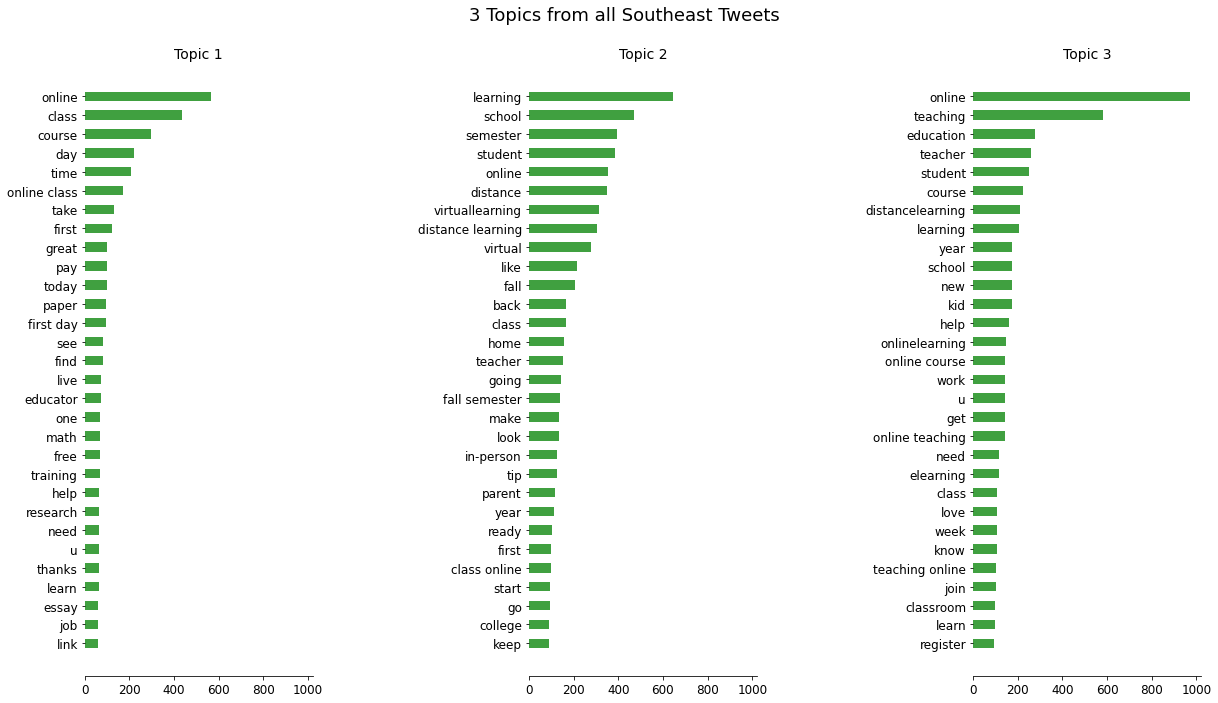

In [115]:
perform_topic_modeling_and_plot(content=southeast_tweets_text, 
                                topic_num=3, 
                                top_word_count=30, 
                                plot_title='3 Topics from all Southeast Tweets',
                                plot_figsize=(20,10),
                                plot_color='green')

## Do topics detected in all Southeast Tweets align with topics detected in Pos/Neg/Neu Southeast Tweets?

### Topic 1: Online Class Logistical Information 
* __SOMEWHAT__ aligned with _Positive Topic 1: Student Virtual/Distance Learning_ and _Neutral Topic 2: Virtual/Distance Learning School Information_ 

### Topic 2: Distance Learning
*  __SOMEWHAT__ aligned with _Negative Topic 3: Distance Learning and Children/Students_

### Topic 3: Online Teaching
* __SOMEWHAT__  aligned with  _Positive Topic 3 :Online teaching_ and _Negative Topic 2: Teaching Online_


## Topic modeling for Alabama 

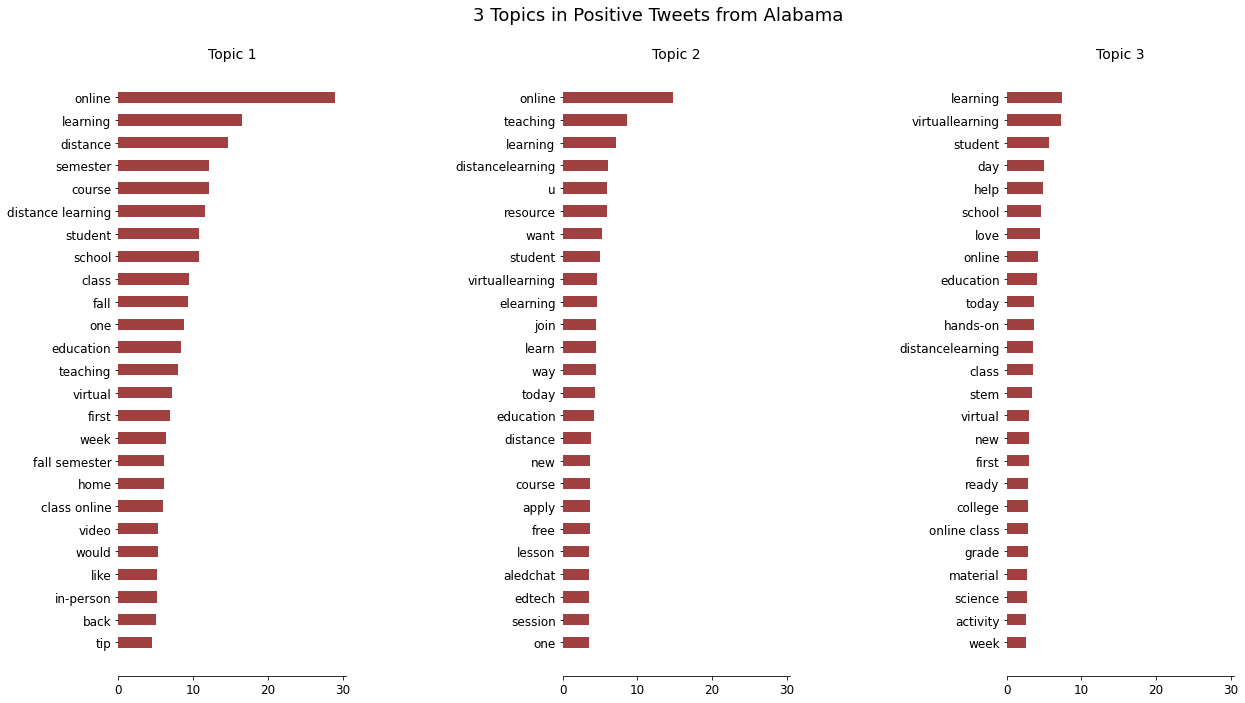

In [112]:
perform_topic_modeling_and_plot(content=alabama_sentiment_series[0], 
                                topic_num=3, 
                                top_word_count=25, 
                                plot_title='3 Topics in Positive Tweets from Alabama',
                                plot_figsize=(20,10),
                                plot_color='maroon')

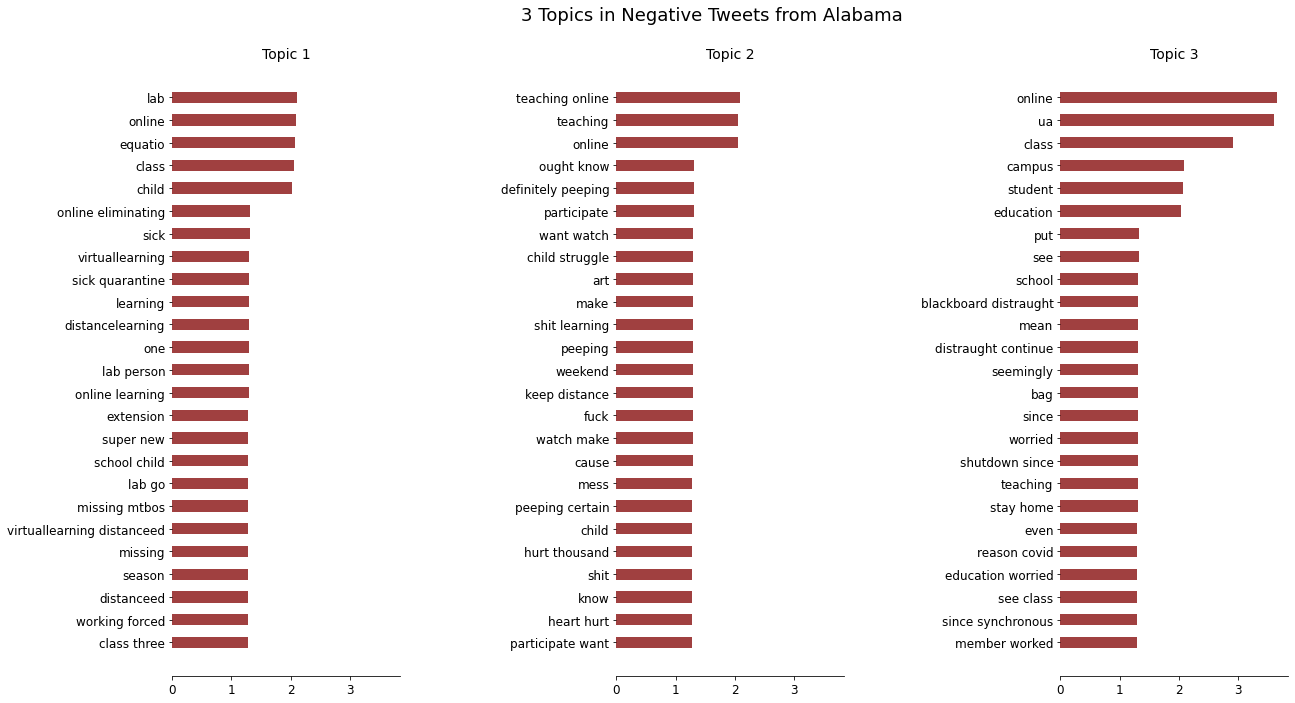

In [113]:
perform_topic_modeling_and_plot(content=alabama_sentiment_series[1], 
                                topic_num=3, 
                                top_word_count=25, 
                                plot_title='3 Topics in Negative Tweets from Alabama',
                                plot_figsize=(20,10),
                                plot_color='maroon')

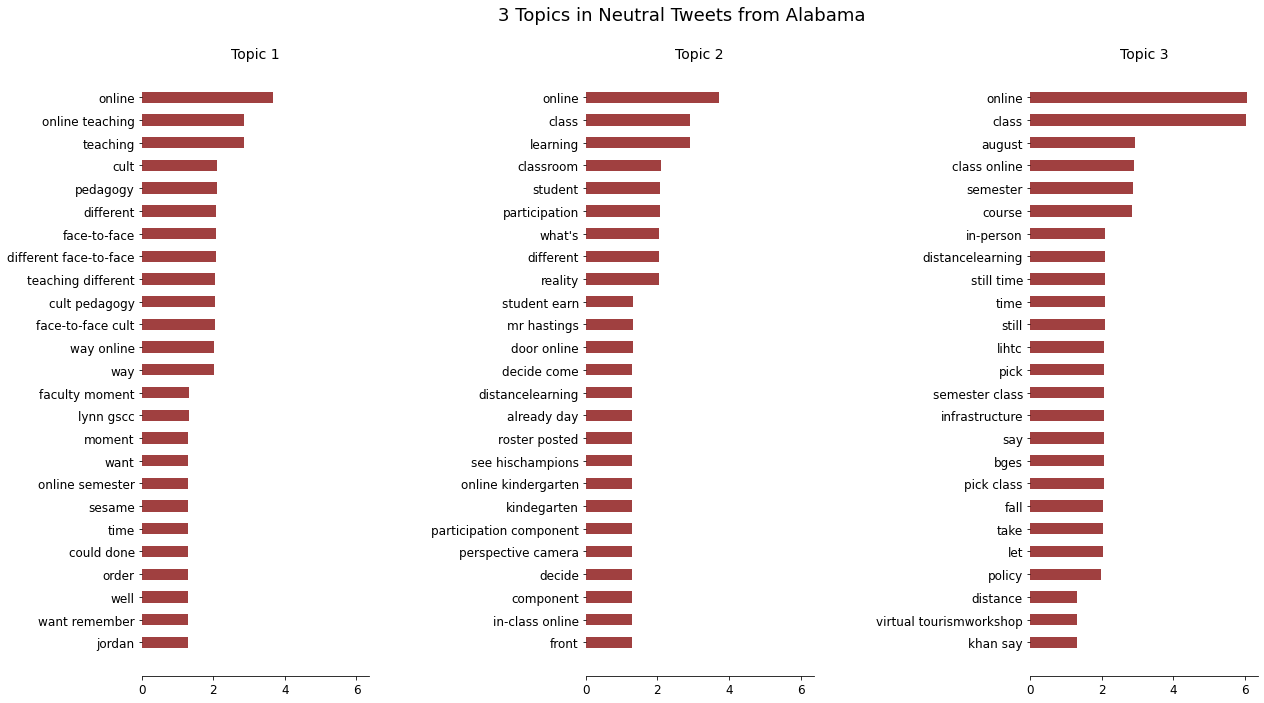

In [114]:
perform_topic_modeling_and_plot(content=alabama_sentiment_series[2],
                                topic_num=3, 
                                top_word_count=25,
                                plot_title='3 Topics in Neutral Tweets from Alabama',
                                plot_figsize=(20, 10),
                                plot_color='maroon')

## Human determined topic descriptions are below:
### Alabama Positive 
#### Topic 1: Online Learning Information
#### Topic 2: Online Teaching/Learning resource sharing
#### Topic 3: Student Online Learning
---------------------------------------------

### Alabama Negative 
#### Topic 1: Online Lab/Class
#### Topic 2: Concerns with Online Teaching 
#### Topic 3: Concerns with Online and Campus 
---------------------------------------------

### Alabama Neutral
#### Topic 1: Comparing Online Teaching to Face-to-Tace Teaching
#### Topic 2: Participation levels during Online Learning
#### Topic 3: Online Class/Course Selection Deadlines

### Dividing all Alabama Tweets into 3 Topics

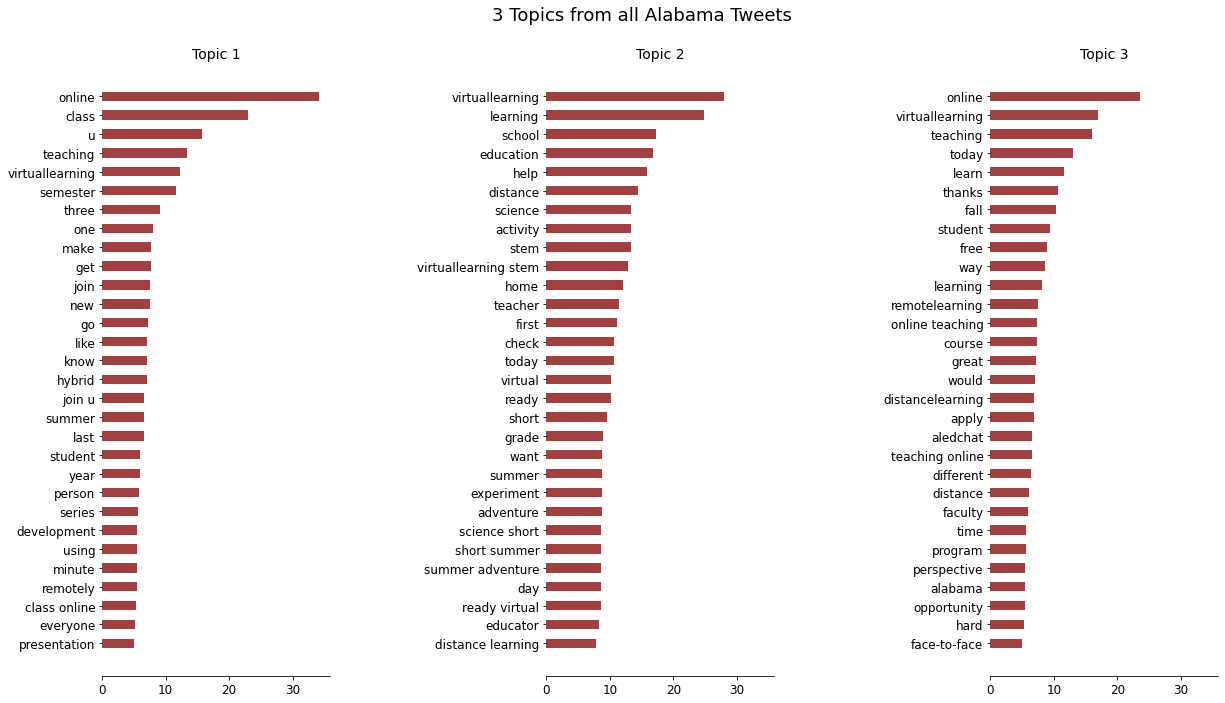

In [116]:
perform_topic_modeling_and_plot(content=alabama_tweets_text, 
                                topic_num=3, 
                                top_word_count=30, 
                                plot_title='3 Topics from all Alabama Tweets',
                                plot_figsize=(20,10),
                                plot_color='maroon')

## Do topics detected in all Alabama Tweets align with topics detected in Pos/Neg/Neu Alabama Tweets?

### Topic 1: Online Class Information
* __SOMEWHAT__ aligned with _Positive Topic 1: Online Learning Information_

### Topic 2: Virtual Learning and STEM
* __SOMEWHAT__ aligned with _Positive Topic 3: Student Online Learning_

### Topic 3: Online Teaching Resources/Support
* __SOMEWHAT__ aligned with _Positive Topic 2: Online Teaching/Learning resource sharing_

## Question 4a: Insights/Recommendations:
Insights: 
* While this notebook only focuses in on a single Region and State, this process could be repeated for any Regions and/or States of interest. 

Recommendations:
* For other Data Scientists seeking to expand upon this work. Topic Modeling complements the Sentiment Classifer and provides contextual insight into the words and terms that people are using in the various Positive, Negative or Neutral Tweets. Topic Modeling is an unsupervised learning technique doesn't have to be trained so it is faster and easier to generate than the Sentiment Classifier (which uses supervised learning requiring labeled data). I recommend using Topic Modeling instead of Word Clouds based on frequent words/terms to provide a more organized method of presenting contextual insight.


## Question 4b: Insights/Recommendations:

Insights:
* When all Tweets are split up into Topics, these topics do appear to span across Sentiment. In one case, we see a fairly strong alignment: when I split all US Tweets into 3 Topics, _Topic 1: Paying for Online Classes or for Online Class Assignments_ was __VERY__ aligned to _Negative Topic 2: Paying for Assignments on many Subjects_.
* This is not too surprising, as documents/Tweets that share a Topic can certainly be presented as Positive, Negative, or Neutral depending on the author.  

Recommendations:
* Learning during COVID-19 is a mutli-facted topic and this prelimary Topic Analysis has just begun to scratch the surface. Classifying Tweets by Sentiment is a great first start. It would useful to create additional Text Classifiers to classify Tweets by Topic first and, after the Topic has been detected, use a Sentiment Classifer to further catagorize the Tweet.

## Future Work:
* Create a dashboard/app that would allow the user to select specific Regions and/or States for Topic Modeling. Also allow for setting the desired number of topics and top word count. 
* Identify specific Topics of interest and train a Text Classifier to classify Tweets according to those Topics. Consider Sentiment Classification after Tweet Topic has been determined.
    * For Example: Create a Text Classifer with Educators in mind.  Detect Tweets on Topics such as Online Teaching Resources, Participation/Engagment Tips for Online Learning, Teacher Professional Development, EdTech Products.